Here are the packages and versions used in this notebook.

In [349]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.20.2
numpy==1.20.2
scipy==1.7.0
cvxpy==1.1.13
matplotlib==2.2.2


Our estimators for Rényi's $\alpha$-cross-entropy are formulated in functional-operator sense.  Specifically, they rely on the notion of convariance operators, which characterize correlations of functions in one or more reproducing-kernel Hilbert spaces.  These operators are approximated using Gram matrices constructed from available samples.

In what follows, we show how to compute the matrix-based cross-entrpy.  We first generate some data.  We draw fifty samples from two-dimensional Gaussian distributions with zero mean and a variance of one half.  We then plot the samples.  We limit ourselves to two dimensions solely for visualization purposes. Our estimator is applicable samples of arbitrary dimensionality with no degradation in performance, as predicted by our theory.

In [1]:
import numpy as np

num_dimensions = 2
num_samples = 50

distrib_mu = 0;
distrib_sigma = 0.5;

X1 = np.random.normal(loc = distrib_mu, scale = distrib_sigma, size = (num_samples, num_dimensions))
X2 = np.random.normal(loc = distrib_mu, scale = distrib_sigma, size = (num_samples, num_dimensions))

<IPython.core.display.Javascript object>


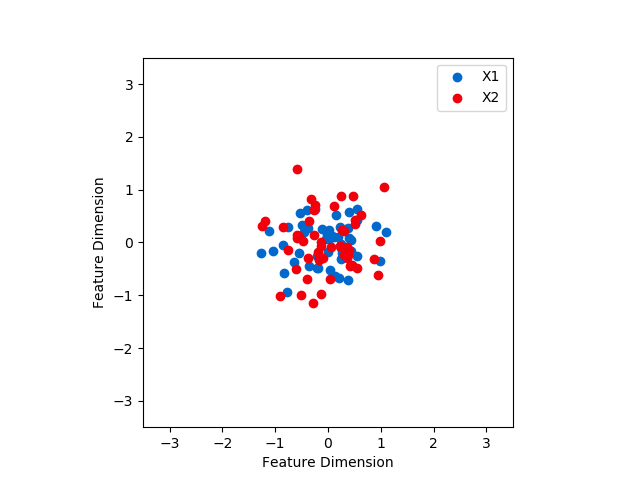

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

# Overlay samples from both distributions on the same scatterplot.
plt.figure()
plt.scatter(X1[:,0],X1[:,1],color=(2./255,105./255,204./255))
plt.scatter(X2[:,0],X2[:,1],color=(241./255,0./255,12./255))
plt.axis([-distrib_sigma-3,distrib_sigma+3,-distrib_sigma-3,distrib_sigma+3])

plt.gca().set_aspect('equal')

# Annotate the plot axes and insert a legend.
plt.xlabel('Feature Dimension')
plt.ylabel('Feature Dimension')
plt.legend(['X1','X2'])
plt.show()

Before going further, we introduce some important concepts.  Specifically, we first need notions of covariance operators in reproducing-kernel Hilbert spaces that correspond to functional autocorrelation.  We refer to these as Gram operators.

> **Definition 1: Univariate Gram Operator.** Let $\mathcal{H}_{\kappa'}$ be a separable, reproducing-kernel Hilbert space that is uniquely specified by a continuous, universal kernel.  We have that $\kappa' \!=\! \langle \varphi(s),\varphi(s') \rangle_{\mathcal{H}_{\kappa}'}$, $s,s' \!\!\in\! \mathcal{S}$, where $\varphi : \mathcal{S} \!\to\! \mathcal{H}_{\kappa'}$ is a measurable feature-map function.  For functions $f,g \!\in\! \mathcal{H}_{\kappa'}$, the univariate Gram operator $\kappa : \mathcal{H}_{\kappa'} \!\to\! \mathcal{H}_{\kappa'}$ is given by the symmetric bilinear form
$$\mathcal{K}(f,g) = \langle f,\kappa g\rangle =\! \int\!\!\!\!\int_{\mathcal{S}}\! \Bigg(\!\langle f,\varphi(s) \rangle_{\mathcal{H}_{\kappa'}} \langle \varphi(s'),g \rangle_{\mathcal{H}_{\kappa'}} \!\!\Bigg) dp_{\mathcal{S}}(s,s')
$$
where $f(s) \!=\! \langle f,\varphi(s)\rangle_{\mathcal{H}_\kappa'}$.  Thus, $\mathcal{K}(f,g) \!=\! \mathbb{E}_{(s,s')\sim p_{\mathcal{S}}}[f(s)g(s')]$, for $s,s' \!\!\in\! \mathcal{S}$, where $p_\mathcal{S} \!\in\! \mathcal{M}^1_+(\mathcal{S})$ is a Borel probability measure on the topological sample space $\mathcal{S}$.
>
> We have that the trace of this operator is
$$\mathrm{tr}(\kappa) = \sum_{j=1}^h \int\!\!\!\!\int_{\mathcal{S}}\! \Bigg(\!\langle \eta_j,\varphi(s) \rangle_{\mathcal{H}_{\kappa'}} \langle \varphi(s'),\eta_j \rangle_{\mathcal{H}_{\kappa'}} \!\!\Bigg) dp_{\mathcal{S}}(s,s'),$$
which follows from $\mathrm{tr}(\kappa) \!=\! \sum_{j=1}^h \mathcal{K}(\eta_j,\cdot)$.  Here, $\{\eta_j\}_{j=1}^h \!\subset\! \mathcal{H}_{\kappa'}$ is a complete orthonormal basis for $\mathcal{H}_{\kappa'}$.

> **Definition 2: Bivariate Gram Operator.** For separable reproducing-kernel Hilbert spaces $\mathcal{H}_{\kappa_1'}$ and $\mathcal{H}_{\kappa_2'}$, with continuous, universal reproducing kernels defined on state-action pairs, let $\kappa'_1((s,a),\cdot) \!=\! \langle \varphi(s,a),\cdot \rangle_{\mathcal{H}_{\kappa_1'}}$ and $\kappa'_2((s,a),\cdot) \!=\! \langle \psi(s,a),\cdot \rangle_{\mathcal{H}_{\kappa_2'}}$, where $\varphi \!:\! \mathcal{S} \!\times\! \mathcal{A} \!\to\! \mathcal{H}_{\kappa_1'}$ and $\psi \!:\! \mathcal{S} \!\times\! \mathcal{A} \!\to\! \mathcal{H}_{\kappa_2'}$ are measurable.  Here, $\mathcal{S},\mathcal{A}$ are topological sample spaces.  Assume that the product kernel is characteristic.  We define the bivariate Gram operator $\gamma$, which is over the quotient, completed Hilbert space, via the symmetric bilinear form
$$\mathcal{G}(f,g) \!=\! \langle f,\gamma g\rangle_{\mathcal{H}_{\kappa_1'} \otimes \,\mathcal{H}_{\kappa_2'}} \!\!\,=\! \int\!\!\!\!\int_{\mathcal{S} \times \mathcal{A}} \Bigg(\!\langle f, \varphi^{\otimes}((s,a),\cdot) \rangle_{\mathcal{H}_{\kappa_1'} \otimes \,\mathcal{H}_{\kappa_2'}} \langle \varphi^{\otimes}((s,a),\cdot),g \rangle_{\mathcal{H}_{\kappa_1'} \otimes \,\mathcal{H}_{\kappa_2'}}\!\Bigg) d\rho_{\mathcal{S} \times \mathcal{A}}((s,a),\cdot).
$$
Here, $f,g \!\in\! \mathcal{H}_{\kappa_1'} \!\otimes\! \mathcal{H}_{\kappa_2'}$.  As well, $\rho_\mathcal{S \times \mathcal{A}} \!\in\! \mathcal{M}^1_+(\mathcal{S} \!\times\! \mathcal{A})$ is a Borel probability measure on the joint topological sample space.
>
> The corresponding trace of this operator is analogous to the univariate case,
$$\mathrm{tr}(\gamma) \!=\! \sum_{q=1}^{r} \int\!\!\!\!\int_{\mathcal{S} \times \mathcal{A}}\! \Bigg(\!\langle \pi_q,\varphi^{\otimes}((s,a),\cdot) \rangle_{\mathcal{H}_{\kappa_1'} \!\otimes \mathcal{H}_{\kappa_2'}} \langle \varphi^{\otimes}((s,a),\cdot),\pi_q \rangle_{\mathcal{H}_{\kappa_1'} \!\otimes \mathcal{H}_{\kappa_2'}} \!\Bigg) d\rho_{\mathcal{S} \times \mathcal{A}}((s,a),\cdot).
$$
Here, $\{\pi_q\}_{j=1}^r \!\subset\! \mathcal{H}_{\kappa_1'} \!\otimes\! \mathcal{H}_{\kappa_2'}$ is a complete orthonormal basis for the quotient, completed Hilbert space.

It should be observed that the traces of the operators are independent of the choice of basis.  This is because any basis of a separable reproducing-kernel Hilbert space contains an orthonormal set.

We can use these Definitions 1 and 2 to specify operator-theoretic versions of Rényi's $\alpha$-cross-entropy.

> **Definition 3: Bipartite, Non-Mirrored Rényi's $\alpha$-Cross-Entropy.** Let $\mathcal{H}_{\kappa_1'}$, $\mathcal{H}_{\kappa_2'}$ be separable reproducing-kernel Hilbert spaces, with continuous, universal reproducing kernels $\kappa_1',\kappa_2'$.  Let $\kappa_1 \!:\! \mathcal{H}_{\kappa_1'} \!\to\! \mathcal{H}_{\kappa_1'}$, $\kappa_2 \!:\! \mathcal{H}_{\kappa_2'} \!\to\! \mathcal{H}_{\kappa_2'}$ be the corresponding Gram operators.  The bipartite, non-mirrored, operator-based R\'{e}nyi's $\alpha$-cross-entropy of $\kappa_1$ and $\kappa_2$, with respect to $\alpha \!\in\! \mathbb{R}_{0,+} \!\backslash \{1\}$, is $\phantom{\int_{a_{b_c}}}$
$$C_\alpha(\kappa_1\|\kappa_2) \!=\! \frac{1}{\alpha \!-\! 1}\mathrm{log}\Bigg(\!\mathrm{tr}(\kappa_1^\alpha\kappa_2^{1-\alpha})\!\Bigg) \!-\! \frac{1}{\alpha \!-\! 1}\mathrm{log}\Bigg(\!\mathrm{tr}(\kappa_1)\!\Bigg),\; \mathrm{for\; supp}(\kappa_2) \!\subseteq\! \mathrm{supp}(\kappa_1), \phantom{\int_{a_{b_c}}}$$
with $C_\alpha(\kappa_1\|\kappa_2) \!=\! \infty$ otherwise.  The expression, $\mathrm{supp}(\kappa_*)$ is the support of $\kappa_*$, i.e., the span of the eigenvectors of $\kappa_*$ corresponding to non-zero eigenvalues; $\kappa_*$ represents either $\kappa_1$ or $\kappa_2$.
>
> Here, $\gamma \!=\! \kappa_1^\alpha\kappa_2^{1-\alpha}$ is a bivariate Gram operator while $\kappa \!=\! \kappa_1$ is a univariate Gram operator.

> **Definition 4: Bipartite, Mirrored Rényi's $\alpha$-Cross-Entropy.** Let $\mathcal{H}_{\kappa_1'}$, $\mathcal{H}_{\kappa_2'}$ be separable reproducing-kernel Hilbert spaces, with continuous, universal reproducing kernels $\kappa_1',\kappa_2'$.  Let $\kappa_1 \!:\! \mathcal{H}_{\kappa_1'} \!\to\! \mathcal{H}_{\kappa_1'}$, $\kappa_2 \!:\! \mathcal{H}_{\kappa_2'} \!\to\! \mathcal{H}_{\kappa_2'}$ be the corresponding Gram operators.  The bipartite, mirrored, operator-based R\'{e}nyi's $\alpha$-cross-entropy of $\kappa_1$ and $\kappa_2$, with respect to $\alpha \!\in\! \mathbb{R}_{0,+} \!\backslash \{1\}$, is $\phantom{\int_{a_{b_c}}}$
$$C'_\alpha(\kappa_1\|\kappa_2) \!=\! \frac{1}{\alpha \!-\! 1}\mathrm{log}\Bigg(\!\mathrm{tr}\Bigg(\!\kappa_2^{\frac{1-\alpha}{2\alpha}} \kappa_1 \kappa_2^{\frac{1-\alpha}{2\alpha}}\!\!\Bigg)^{\!\!\alpha}\,\!\Bigg) \!-\! \frac{1}{\alpha \!-\! 1}\mathrm{log}\Bigg(\!\mathrm{tr}(\kappa_1)\!\Bigg),\; \mathrm{for\; supp}(\kappa_2) \!\subseteq\! \mathrm{supp}(\kappa_1), \phantom{\int_{a_{b_c}}}$$
with $C_\alpha(\kappa_1\|\kappa_2) \!=\! \infty$ otherwise.  The expression, $\mathrm{supp}(\kappa_*)$ is the support of $\kappa_*$, i.e., the span of the eigenvectors of $\kappa_*$ corresponding to non-zero eigenvalues; $\kappa_*$ represents either $\kappa_1$ or $\kappa_2$.
>
> Here, $\gamma \!=\! (\kappa_2^{(1-\alpha)/2\alpha} \kappa_1 \kappa_2^{(1-\alpha)/2\alpha})^\alpha$ is a bivariate Gram operator while $\kappa \!=\! \kappa_1$ is a univariate Gram operator.

In these cross-entropy measures, the arguments of the log expression can be viewed as transformations that transfer statistical properties of the measures to reproducing-kernel Hilbert spaces.  This follows from the above-established theory.  The second log term acts as a normalizer; it is consistent with what Rényi proposed for incomplete distributions.

The trace of the Gram operators assume access to a basis for the corresponding reproducing-kernel Hilbert spaces.  Although bases provably exist, specifying them can be difficult.  We therefore consider an approximation strategy wherein we replace the Gram operators with empirical Gram matrices.  The spectral properties of the emirical Gram matrices and operators are consistent.

> **Proposition 1: Univariate Gram Operator Approximation.** Let $\mathcal{H}_{\kappa'}$ be a separable reproducing-kernel Hilbert space with a continuous, universal reproducing kernel.  Let $\kappa'(s,s') \!=\! \langle \varphi(s),\varphi(s')\rangle_{\mathcal{H}_{\kappa'}}$, where $\varphi \!:\! \mathcal{S} \!\to\! \mathcal{H}_{\kappa'}$ is a measurable feature-map function.  An unbiased empirical estimate $\hat{\kappa}(f,g)$, $f,g \!\in\! \mathcal{H}_{\kappa'}$, of the symmetric, self-adjoint operator $\kappa$ is
$$
\hat{\kappa}(f,g) = \langle f,\hat{\kappa} g \rangle_{\mathcal{H}_{\kappa'}} \!=\! \int\!\!\!\!\int_{\mathcal{S}} \Bigg(\!\langle f, \varphi(s_i) \rangle_{\mathcal{H}_{\kappa'}} \langle \varphi(s'),g \rangle_{\mathcal{H}_{\kappa'}}\! \Bigg)d\hat{p}_{\mathcal{S}}(s_i,s')
$$
which evaluates to $n^{-1}\!\sum_{i=1}^n \langle f, \varphi(s_i) \rangle_{\mathcal{H}_{\kappa'}} \langle \varphi(s'),g \rangle_{\mathcal{H}_{\kappa'}}$, where $s_i,s' \!\in\! \mathcal{S}$, $i \!\in\! \mathbb{N}_{1,n}$, are samples.  This corresponds to replacing $p_{\mathcal{S}}$ with an empirical version $\hat{p}_{\mathcal{S}} \!\in\! \mathcal{M}^1_+(\mathcal{S})$ formed by a series of $n$ Dirac measures $\delta_{s_i}$, $\hat{p}_{\mathcal{S}} \!=\! \sum_{i=1}^n \delta_{s_i}/n$.  We thus have $\mathbb{E}[\hat{\kappa}] \!=\! \kappa$.
>
> Moreover, let $[\hat{\kappa}]_{i,j} \!=\! \langle \varphi(s_i),\varphi(s_j) \rangle_{\mathcal{H}_{\kappa'}}$, $[\hat{\kappa}] \!\in\! \mathbb{R}_{0,+}^{n \times n}$, being an empirical Gram matrix. $\hat{\kappa}$ has at most $n$ positive eigenvalues, $\beta_i \!\in\! \mathbb{R}_{0,+}$, which satisfy $[\hat{\kappa}]v_i/n \!=\! \beta_iv_i$. $n \beta_i$ are also all positive eigenvalues of the empirical Gram matrix $[\hat{\kappa}]$.

> **Proposition 2: Bivariate Gram Operator Approximation.** Let $\mathcal{H}_{\kappa'_1}$, $\mathcal{H}_{\kappa'_2}$ be separable reproducing-kernel Hilbert spaces with continuous, universal reproducing kernels $\kappa_1',\kappa_2'$.  let $\kappa'_1((s,a),\cdot) \!=\! \langle \varphi(s,a),\cdot \rangle_{\mathcal{H}_{\kappa_1'}}$ and $\kappa'_2((s,a),\cdot) \!=\! \langle \psi(s,a),\cdot \rangle_{\mathcal{H}_{\kappa_2'}}$, where $\varphi \!:\! \mathcal{S} \!\times\! \mathcal{A} \!\to\! \mathcal{H}_{\kappa_1'}$ and $\psi \!:\! \mathcal{S} \!\times\! \mathcal{A} \!\to\! \mathcal{H}_{\kappa_2'}$ are measurable feature-map functions.  An unbiased empirical estimate $\hat{\gamma}(f,g)$, $f,g \!\in\! \mathcal{H}_{\kappa'_1} \!\otimes\! \mathcal{H}_{\kappa'_2}$, of the symmetric, self-adjoint operator $\gamma$ is
$$
\hat{\gamma}(f,g) = \langle f,\hat{\kappa} g \rangle_{\mathcal{H}_{\kappa'_1} \otimes \mathcal{H}_{\kappa'_2}} =\! \int\!\!\!\!\int_{\mathcal{S} \times \mathcal{A}} \langle f, \varphi^{\otimes}((s_i,a_i),\cdot) \rangle_{\mathcal{H}_{\kappa_1'} \otimes \,\mathcal{H}_{\kappa_2'}} \langle \varphi^{\otimes}((s_i,a_i),\cdot),g \rangle_{\mathcal{H}_{\kappa_1'} \otimes \,\mathcal{H}_{\kappa_2'}} d\hat{\rho}_{\mathcal{S} \times \mathcal{A}}((s_i,a_i),\cdot)
$$
which evaluates to $n^{-1}\!\sum_{i=1}^n \langle f, \varphi^\otimes(s_i,a_i) \rangle_{\mathcal{H}_{\kappa'_1} \otimes \mathcal{H}_{\kappa'_2}} \langle \varphi^\otimes(s',a'),g \rangle_{\mathcal{H}_{\kappa'_1} \otimes \mathcal{H}_{\kappa'_2}}$, where $s_i,s' \!\in\! \mathcal{S}$, $a_i,a' \!\in\! \mathcal{A}$, $i \!\in\! \mathbb{N}_{1,n}$, are samples.  This corresponds to replacing $\rho_{\mathcal{S} \times \mathcal{A}}$ with an empirical version $\hat{p}_{\mathcal{S} \times \mathcal{A}} \!\in\! \mathcal{M}^1_+(\mathcal{S} \!\times\! \mathcal{A})$ formed by a series of $n$ Dirac measures $\delta_{s_i,a_i}$, $\hat{p}_{\mathcal{S} \times \mathcal{A}} \!=\! \sum_{i=1}^n \delta_{s_i,a_i}/n$.  We thus have $\mathbb{E}[\hat{\gamma}] \!=\! \gamma$.
>
> Moreover, let $[\hat{\gamma}]_{i,j} \!=\! \langle \varphi(s_i,a_i),\psi(s_j,a_j) \rangle_{\mathcal{H}_{\kappa'_1} \otimes \mathcal{H}_{\kappa'_2}}$, $[\hat{\gamma}] \!\in\! \mathbb{R}_{0,+}^{n \times n}$, being an empirical Gram matrix. $\hat{\gamma}$ has at most $n$ positive eigenvalues, $\beta_i \!\in\! \mathbb{R}_{0,+}$, which satisfy $[\hat{\gamma}]v_i/n \!=\! \beta_iv_i$. $n \beta_i$ are also all positive eigenvalues of the empirical Gram matrix $[\hat{\gamma}]$.

Due to the spectral consistency, the empirical Gram matrices can be inserted in place of the Gram operators in Definitions 3 and 4.  This yields matrix-based Rényi's $\alpha$-cross-entropy estimators.

Now we will form the empirical Gram matrices $[\hat{\kappa}_1]$ and $[\hat{\kappa}_2]$, which are approximations of the Gram operators $\kappa_1$ and $\kappa_2$.  We do this by forming the matrix of pairwise distances between each sample and then applying a reproducing kernel.  We will use a Gaussian kernel with a bandwidth of 1.0.  This is is a universal, translation-invariant kernel.  We then visualize the axi-symmetric, non-negative Gram matrices.

In [3]:
from scipy.spatial.distance import squareform, pdist

ker_bandwidth = 1.0

# Form the Gram matrices using the Gaussian kernel.  This is a positive, bounded
# kernel that is translation invariant.  It also is provably universal, which implies
# that the product kernel will be characteristic and hence will lead to injective
# mappings that separate distributions in the reproducing-kernel Hilbert space.
kappa1 = np.exp(-squareform(pdist(X1))/ker_bandwidth)
kappa2 = np.exp(-squareform(pdist(X2))/ker_bandwidth)

# Normalize the Gram matrices so that the underlying kernels are infinitely divisible.
kappa1=kappa1/kappa1.shape[0]
kappa2=kappa2/kappa1.shape[0]

<IPython.core.display.Javascript object>


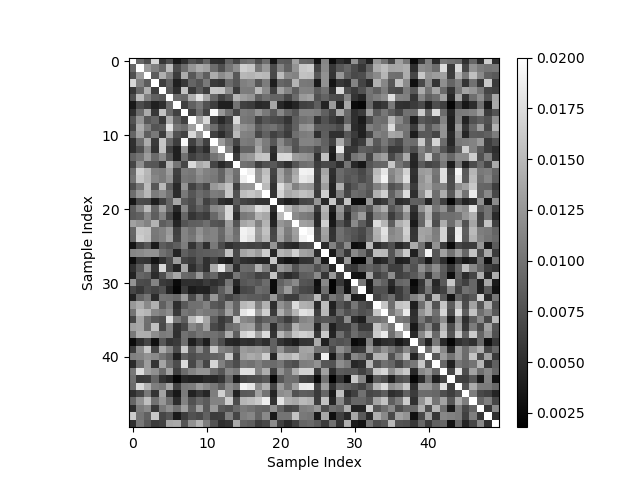

In [4]:
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

plt.figure()

# Plot the Gram matrix.  Use a grayscale colormap, where darker values indicate
# lower similarity and lighter values higher similarity.
ax = plt.gca()
im = ax.imshow(kappa1, cmap=plt.get_cmap('gray'))

# Annotate the similarity plot axes.  Set the plot properties.
plt.xlabel('Sample Index')
plt.ylabel('Sample Index')
plt.gca().set_aspect('equal')

# Insert a colorbar on the right-hand side of the similarity plot that is of the
# same size as the plot.
divider = make_axes_locatable(ax)
width = axes_size.AxesY(ax, aspect=1./1)
pad = axes_size.Fraction(0.05, width)
cax = divider.append_axes('right', size=0.095, pad=pad)
plt.colorbar(im, cax=cax)

plt.show()

<IPython.core.display.Javascript object>


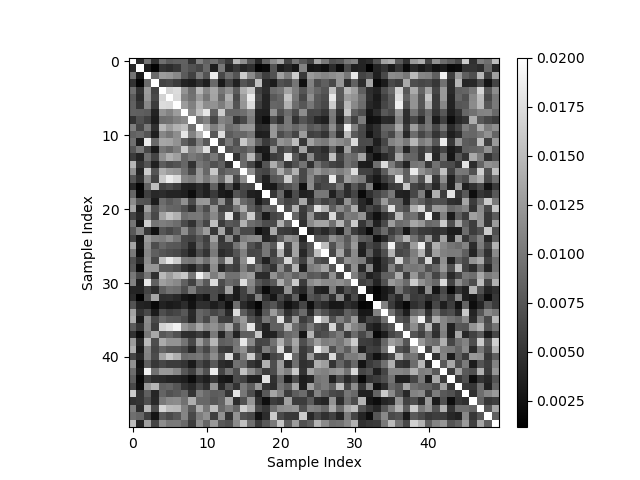

In [5]:
plt.figure()

# Plot the Gram matrix.  Use a grayscale colormap, where darker values indicate
# lower similarity and lighter values higher similarity.
ax = plt.gca()
im = ax.imshow(kappa2, cmap=plt.get_cmap('gray'))

# Annotate the similarity plot axes.  Set the plot properties.
plt.xlabel('Sample Index')
plt.ylabel('Sample Index')
plt.gca().set_aspect('equal')

# Insert a colorbar on the right-hand side of the similarity plot that is of the
# same size as the plot.
divider = make_axes_locatable(ax)
width = axes_size.AxesY(ax, aspect=1./1)
pad = axes_size.Fraction(0.05, width)
cax = divider.append_axes('right', size=0.095, pad=pad)
plt.colorbar(im, cax=cax)

plt.show()

We now can compute the matrix-based $\alpha$-cross-entropy for increasing values of $\alpha \!\in\! \mathbb{R}_{0,1} \backslash \{0,1\}$.  We do this for the non-mirrored case, $C_\alpha([\kappa_1]\|[\kappa_2])$.  We limit ourselves to $\alpha \!\in\! \mathbb{R}_{0,2} \backslash \{0,2\}$, since the cross-entropy measure only satisfies the data-processing inequality on this range.  If a larger value of $\alpha$ is to be used, then the mirrored case, $C_\alpha'([\kappa_1]\|[\kappa_2])$, should be employed.  It satisfies the data-processing inequality for $\alpha \!\in\! \mathbb{R}_{\frac{1}{2},+} \!\backslash \{\frac{1}{2}\}$.

It is important to ensure that both $[\kappa_1]$ and $[\kappa_2]$ are well-conditioned matrices.  This can be done via matrix equilibration.

In [151]:
from cvxpy import *

def matrix_equilibrate(A, p=2):
    B = np.power(np.abs(A), p)

    obj = 0
    u = Variable(A.shape[0])
    v = Variable(A.shape[1])

    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            obj += exp(log(B[i,j]) + u[i] + v[j])

    obj = Minimize(obj)
    constraints = [sum(u)==0, sum(v)==0]
    prob = Problem(obj, constraints)
    prob.solve(verbose=False)
    
    D = np.diagflat(np.exp(u.value/p))
    E = np.diagflat(np.exp(v.value/p))
    
    return D * A * E

We now consider a more interesting example where we change the distributional variance in one dimension for one of the sample sets.  We then assess the matrix-based cross-entropy for a range of $\alpha \!\in\! \mathbb{R}_{0,1} \!\backslash \{0,1\}$.  We do this for the non-mirrored case, $C_\alpha([\kappa_1]\|[\kappa_2])$.

Qualitatively, we expect that for variance scale amounts near zero, $C_\alpha([\kappa_1]\|[\kappa_2])$ should be high.  This is because the samples for one of the sets should have collapsed to a delta function.  There thus is little overlap with the other set.  As the variance scale amount increases towards one, $C_\alpha([\kappa_1]\|[\kappa_2])$ should monotonically decrease.  The minimal value of $C_\alpha([\kappa_1]\|[\kappa_2])$ should be achieved around the unit-variance case, as the distributions will have, roughly, the same spread and thus overlap well.  Past this threshold, $C_\alpha([\kappa_1]\|[\kappa_2])$ should monotonically increase.  We expect monotonicity in $\alpha$, as guaranteed by our theory.

Note that for the above setup, it is not actually necessary to perform matrix conditioning.  We thus skip it in the following example so as to reduce the overall computation time.  For other kernels and kernel parameters, it may be necessary.

In [6]:
from scipy.linalg import fractional_matrix_power

# @function: nonmirrored_renyi_cross_entropy
# @date-created: 07-31-2021
# @date-modified: 07-31-2021
# @description: Returns the matrix-based bipartite, non-mirrored Rényi's alpha-cross-entropy for
#     a pair of non-zero, normalized, square Gram matrices.
# @note: The Gram matrices should be specified using universal kernels.  This is to ensure that the
#     kernel associated with the bivariate Gram operator is characteristic and hence that the mean-
#     element map exists.  It is also recommended that both Gram matrices be constructed using the
#     same kernel with the same hyperparameters.
#
# @param kappa1: Square, normalized Gram matrix for the samples from the first set. (nxn float/double)
# @param kappa2: Square, normalized Gram matrix for the samples from the second set. (nxn float/double)
# @param alpha: Order of the Rényi's cross-entropy. (float/double)
#
# @return: Bipartite non-mirrored cross-entropy magnitude, which specifies the distributional overlap.
#     Low values denote that the probability densities, as characterized by the Gram matrices, are 
#     similar. (float/double)
def nonmirrored_renyi_cross_entropy(kappa1, kappa2, alpha=0.99):
    # Make sure that the cross-entropy order, alpha, is within the valid range.  Rényi's cross-entropy
    # does not satisfy the properties of a divergence for non-positive alphas.  Likewise, it is not
    # defined for an order of one, due to division by zero.
    if((alpha <= 0) or (alpha == 1)):
        raise Exception('The cross-entropy order, alpha, cannot be one and cannot be non-positive.')

    # Determine if the Gram matrices adhere to certain standard properties.  The Gram matrices, currently,
    # cannot be more than two dimensions.  Moreover, the Gram matrices must be square and have the same
    # number of entries for the bipartite measures.
    if(len(kappa1.shape) != 2 or len(kappa2.shape) != 2): 
        raise Exception('Both Gram matrices can only have two dimensions.')
    if(kappa1.shape != kappa2.shape): 
        raise Exception('Both Gram matrices must have the same size.  Check how you compute the Gram matrices.')
    if((kappa1.shape[0] != kappa1.shape[1]) or (kappa2.shape[0] != kappa2.shape[1])): 
        raise Exception('Both Gram matrices must be square.  Check how you compute the Gram matrices.')

    # Compute the non-mirrored cross-entropy.  We could explicitly compute the eigenvalues and eigenvectors
    # of the Gram matrices to do this, but it's more convenient to just use fractional_matrix_power() instead.
    return np.abs(np.log(np.trace(np.matmul(fractional_matrix_power(kappa1, alpha), fractional_matrix_power(kappa2, 1-alpha))))/(alpha-1)) - np.abs(np.log(np.trace(kappa1))/(alpha-1))

In [9]:
# @function: mirrored_renyi_cross_entropy
# @date-created: 07-31-2021
# @date-modified: 07-31-2021
# @description: Returns the matrix-based bipartite, mirrored Rényi's alpha-cross-entropy for
#     a pair of non-zero, normalized, square Gram matrices.
# @note: The Gram matrices should be specified using universal kernels.  This is to ensure that the
#     kernel associated with the bivariate Gram operator is characteristic and hence that the mean-
#     element map exists.  It is also recommended that both Gram matrices be constructed using the
#     same kernel with the same hyperparameters.
#
# @param kappa1: Square, normalized Gram matrix for the samples from the first set. (nxn float/double)
# @param kappa2: Square, normalized Gram matrix for the samples from the second set. (nxn float/double)
# @param alpha: Order of the Rényi's cross-entropy. (float/double)
#
# @return: Bipartite non-mirrored cross-entropy magnitude, which specifies the distributional overlap.
#     Low values denote that the probability densities, as characterized by the Gram matrices, are 
#     similar. (float/double)
def mirrored_renyi_cross_entropy(kappa1, kappa2, alpha=0.99):
    # Make sure that the cross-entropy order, alpha, is within the valid range.  Rényi's cross-entropy
    # does not satisfy the properties of a divergence for non-positive alphas.  Likewise, it is not
    # defined for an order of one, due to division by zero.
    if((alpha <= 0) or (alpha == 1)):
        raise Exception('The cross-entropy order, alpha, cannot be one and cannot be non-positive.')

    # Determine if the Gram matrices adhere to certain standard properties.  The Gram matrices, currently,
    # cannot be more than two dimensions.  Moreover, the Gram matrices must be square and have the same
    # number of entries for the bipartite measures.
    if(len(kappa1.shape) != 2 or len(kappa2.shape) != 2): 
        raise Exception('Both Gram matrices can only have two dimensions.')
    if(kappa1.shape != kappa2.shape): 
        raise Exception('Both Gram matrices must have the same size.  Check how you compute the Gram matrices.')
    if((kappa1.shape[0] != kappa1.shape[1]) or (kappa2.shape[0] != kappa2.shape[1])): 
        raise Exception('Both Gram matrices must be square.  Check how you compute the Gram matrices.')

    # Compute the mirrored cross-entropy.  We could explicitly compute the eigenvalues and eigenvectors
    # of the Gram matrices to do this, but it's more convenient to just use fractional_matrix_power() instead.
    return np.abs(np.log(np.power(np.trace(np.matmul(np.matmul(fractional_matrix_power(kappa2, (1-alpha)/(2*alpha)), kappa1), fractional_matrix_power(kappa2, (1-alpha)/(2*alpha)))), alpha))/(alpha-1)) - np.abs(np.log(np.trace(kappa1))/(alpha-1))

In [10]:
from copy import *

# Create a place-holder matrix to store the cross-entropy magnitudes.  This will be indexed by
# variables i and j.
Cnm = np.zeros((len(np.arange(0.05,0.96,0.05)), len(np.arange(0.05,3.05,0.05))))

i = 0
# We will be illustrating the influence of distributional variance changes on the cross-entropy
# magnitudes.  We therefore consider variance scale amounts in the range of 0.05 to 3.
for scale in np.arange(0.05,3.05,0.05):
    j = 0
    # Copy the original dataset so that the entries can be modified separately.  Scale the magnitudes 
    # of the samples in its first dimension.
    X1_temp = copy(X1)
    X1_temp[:,0] = X1_temp[:,0] * scale;
    # Form the Gram matrix for the modified dataset using the Gaussian kernel.  Use the same 
    # hyperparameter values as the second Gram matrix for consistency.  You may encounter weird 
    # results if you consider different kernels with different hyperparameter values.  Also, we 
    # shouldn't need to condition the Gram matrices in this case, so we skip this step.
    kappa1_temp = np.exp(-squareform(pdist(X1_temp))/ker_bandwidth)
    # Make sure that the Gaussian kernel is implicitly transformed so that it is infinitely-
    # divisible, which is done via normalizing the Gram matrix entries.  Without this step, then 
    # the cross-entropy magnitudes will be negative, not positive.  Also we won't be able to 
    # recover our matrix-based entropies and mutual informations using the cross-entropy measure.
    kappa1_temp = kappa1_temp/kappa1_temp.shape[0]
    # Sweep over the cross-entropy order and compute the bipartite, non-mirrored cross-entropy.  
    # Iterating over values of alpha illustrates what happens as metric in the probability simplex changes.
    for alpha in np.arange(0.05,0.96,0.05):
        Cnm[j,i] = nonmirrored_renyi_cross_entropy(kappa1_temp, kappa2, alpha)
        j += 1
    i += 1

<IPython.core.display.Javascript object>


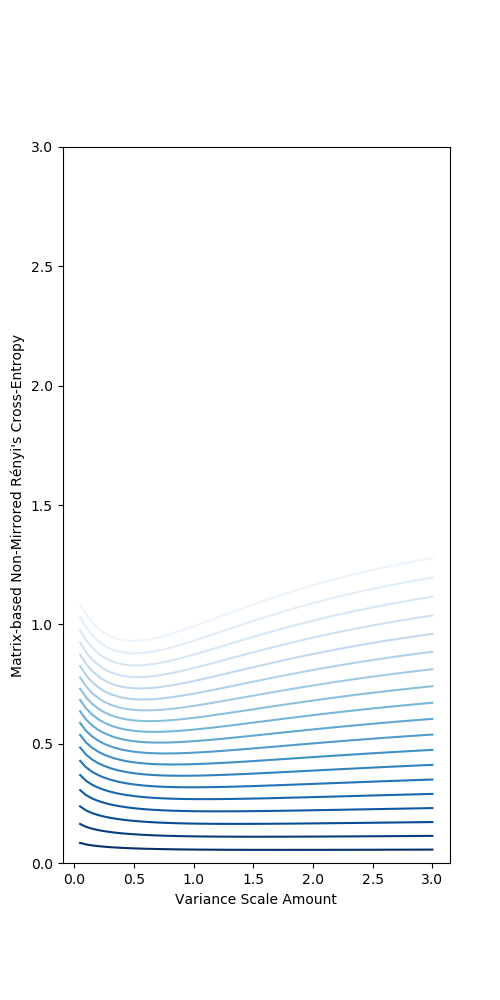

In [12]:
import matplotlib as mpl

# Create a colormap where darker blues correspond to low cross-entropy orders and lighter 
# blues to higher cross-entropy orders.
cmap = mpl.cm.get_cmap('Blues', len(np.arange(0.05,0.96,0.05))+1).reversed()

plt.figure()
# Plot each of the rows of the non-mirrored cross-entropy matrix.
for j in range(Cnm.shape[0]):
    plt.plot(np.arange(0.05,3.05,0.05), Cnm[j,:], color=cmap(j))

# Annotate the plot.  Set the plot properties.
plt.xlabel('Variance Scale Amount')
plt.ylabel('Matrix-based Non-Mirrored Rényi\'s Cross-Entropy')
plt.gca().set_ylim([0,3])
plt.gca().set_aspect(2)
mpl.pyplot.gcf().set_size_inches(5,10)

plt.show()

Above, we plot $C_\alpha([\kappa_1]\|[\kappa_2])$ for increasing values of $\alpha$ in progressively lighter shades of blue.  The results align well with our expectations. 

We observe that small values of the cross-entropy order, $\alpha$, yield mostly flat cross-entropy magnitudes.  This is natural.  The variable $\alpha$ is controlling properties of a metric distance in the probability simplex.  As $\alpha \!\to\! 0$, any point in the simplex, aside from the corners, will have nearly the same distance to all other points in the simplex.  This is because the metric distance approaches a 0-norm distance.  As $\alpha \!\to\! \infty$, the metric distance approaches an $\infty$-norm distance.

One of the most important theoretical results for our matrix-based cross-entropies is that the convergence rate of the Gram operator approximations to the Gram operators is independent of the sample dimensionality.  The convergence rate solely depends on the number of samples.

> **Proposition 3: Univariate Gram Operator Approximation Convergence.** Let $\mathcal{H}_{\kappa'}$ be a separable reproducing-kernel Hilbert space.  Let $\hat{\kappa}$ be an approximate Gram operator and $[\hat{\kappa}] \!\in\! \mathbb{R}_{0,+}^{n \times n}$ be the corresponding normalized Gram matrix.  Assume that the corresponding kernel $\kappa'$ is continuous and universal.  We have that, for $\alpha \!\in\! \mathbb{R}_+ \!\backslash \{1\}$,
>
> Let $[\hat{\kappa}_1],[\hat{\kappa}_2] \!\in\! \mathbb{R}_{0,+}^{n \times n}$ be empirical Gram matrices, where $[\kappa_1]_{i,j} \!=\! \langle \varphi(s_i),\varphi(s_j)\rangle_{\mathcal{H}_{\kappa'}}\!$ and $[\kappa_2]_{i,j} \!=\! \langle \psi(a_i),\psi(a_j)\rangle_{\mathcal{H}_{\kappa'}}$.  We have that, for the bipartite, non-mirrored cross-entropy
>
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(i) $\mathrm{tr}(\hat{\kappa}) \!=\! \mathrm{tr}([\hat{\kappa}])$.<br>
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(ii) For the univariate operator $\kappa$, the inequality $|\mathrm{tr}(\kappa) \!-\! \mathrm{tr}(\hat{\kappa})| \!\leq\! c_1 (2\mathrm{log}(2/\delta)/n)^{1/2}$ is satisfied with $1\!-\!\delta$, where the kernel magnitudes obey $\kappa' \!\leq\! c_1$, with $c_1 \!\in\! \mathbb{R}_+$.  Here, $\mathrm{tr}(\kappa) \!=\! \sum_{j=1}^h \langle \eta_j,\kappa \eta_j \rangle_{\mathcal{H}_{\kappa'_1}}$, where $\eta_j$ are elements of the orthonormal basis for $\mathcal{H}_{\kappa'}$.<br>
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(iii) The inequality $\mathrm{inf}_{\hat{\kappa}}\, \mathrm{sup}_{\kappa}\, \|\mathrm{tr}([\hat{\kappa}]) \!-\! \mathrm{tr}(\kappa)\|_{\mathcal{H}_{\kappa'}} \!\geq\! c_2(2c_3/n)^{1/2}$ is satisfied with non-zero probability, where $c_2,c_3 \!\in\! \mathbb{R}_+$ do not depend on the dimensionality of the samples.  Hence, the trace of the univariate Gram matrix is minimax optimal.

> **Proposition 4: Bivariate Gram Operator Approximation Convergence.**  Let $\mathcal{H}_{\kappa'_1}$, $\mathcal{H}_{\kappa'_2}$ be separable reproducing-kernel Hilbert spaces.  Let $\hat{\kappa_1},\hat{\kappa_2}$ be approximate univariate Gram operators and $[\hat{\kappa}_1],[\hat{\kappa}_2] \!\in\! \mathbb{R}_{0,+}^{n \times n}$ be the corresponding normalized Gram matrices.  Assume that the corresponding kernel $\kappa'_1,\kappa_2'$ are continuous and universal.  Moreover, assume that $\hat{\gamma}$ and $[\hat{\gamma}] \!\in\! \mathbb{R}_{0,+}^{n \times n}$ are, respectively, continuous combinations of $\hat{\kappa}_1,\hat{\kappa}_2$ and $[\hat{\kappa}_1],[\hat{\kappa}_2]$.  We have that,
>
> Let $[\hat{\kappa}_1],[\hat{\kappa}_2] \!\in\! \mathbb{R}_{0,+}^{n \times n}$ be empirical Gram matrices, where $[\kappa_1]_{i,j} \!=\! \langle \varphi(s_i),\varphi(s_j)\rangle_{\mathcal{H}_{\kappa'}}\!$ and $[\kappa_2]_{i,j} \!=\! \langle \psi(a_i),\psi(a_j)\rangle_{\mathcal{H}_{\kappa'}}$.  We have that, for the bipartite, non-mirrored cross-entropy
>
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(i) $\mathrm{tr}(\hat{\gamma}) \!=\! \mathrm{tr}([\hat{\gamma}])$, where $[\hat{\gamma}] \!=\! [\hat{\kappa}_1]^\alpha[\hat{\kappa}_2]^{1-\alpha}$ or $[\hat{\gamma}] \!=\! [\kappa_2]^{(1-\alpha)/2\alpha} [\kappa_1] [\kappa_2]^{(1-\alpha)/2\alpha}$, with $\hat{\gamma}$ having anaogous forms.<br>
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(ii) For the bivariate operator $\gamma$, the inequality $|\mathrm{tr}(\gamma) \!-\! \mathrm{tr}(\hat{\gamma})| \!\leq\! \alpha c_1c_2c_3 (2\mathrm{log}(2/\delta)/n)^{1/2}$ is satisfied with probability $1 \!-\! \delta$.  We assume that the kernel magnitudes obey $\kappa'_1 \!\leq\! c_1$ and $\kappa'_2 \!\leq\! c_2$, with $c_1,c_2 \!\in\! \mathbb{R}_+$.  $c_3 \!\in\! \mathbb{R}_+$ takes the value $c_3 \!=\! 1$ for the non-mirrored case and $c_3 \!=\! \alpha$ for the mirrored case.  For both cross-entropies, $\mathrm{tr}(\gamma) \!=\! \sum_{q=1}^r \langle \pi_q,\gamma \pi_q \rangle_{\mathcal{H}_{\kappa'_1} \otimes \mathcal{H}_{\kappa'_2}}$, where $\pi_q$ are elements of the orthonormal basis for $\mathcal{H}_{\kappa'_1} \!\otimes\! \mathcal{H}_{\kappa'_2}$.<br>
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(iii) The inequality $\mathrm{inf}_{\hat{\gamma}}\, \mathrm{sup}_{\gamma}\, \|\mathrm{tr}(\hat{\gamma}) \!-\! \mathrm{tr}(\gamma)\|_{\mathcal{H}_{\kappa'_1} \otimes \mathcal{H}_{\kappa'_2}} \!\geq\! c_4(2c_5/n)^{1/2}$ is satisfied with non-zero probability, for constants $c_4,c_5 \!\in\! \mathbb{R}_+$ that do not depend on the dimensionality of the samples.  Hence, the trace of the bivariate Gram matrix is minimax optimal.

We can empirically show that this is the case.

In [69]:
# Create a place-holder matrix to store the cross-entropy magnitudes.  This will be indexed by
# variables i and j.
Cnm50 = np.zeros((len(np.arange(0.05,0.96,0.05)), len(np.arange(100, 2100, 100))))

i = 0
num_dimensions = 50
for num_samples in np.arange(100, 2100, 100):
    j = 0
    # Drawn num_samples from Gaussian distributions with a variance of 0.25
    X1_temp = np.random.normal(loc = distrib_mu, scale = 0.25, size = (num_samples, num_dimensions))
    X2_temp = np.random.normal(loc = distrib_mu, scale = 0.25, size = (num_samples, num_dimensions))
    # Form the Gram matrix for the modified dataset using the Gaussian kernel.  Use the same 
    # hyperparameter values as the second Gram matrix for consistency.  You may encounter weird 
    # results if you consider different kernels with different hyperparameter values.  Also, we 
    # shouldn't need to condition the Gram matrices in this case, so we skip this step.
    kappa1_temp = np.exp(-squareform(pdist(X1_temp))/ker_bandwidth)
    kappa2_temp = np.exp(-squareform(pdist(X2_temp))/ker_bandwidth)
    # Make sure that the Gaussian kernel is implicitly transformed so that it is infinitely-
    # divisible, which is done via normalizing the Gram matrix entries.  Without this step, then 
    # the cross-entropy magnitudes will be negative, not positive.  Also we won't be able to 
    # recover our matrix-based entropies and mutual informations using the cross-entropy measure.
    kappa1_temp = kappa1_temp/kappa1_temp.shape[0]
    kappa2_temp = kappa2_temp/kappa1_temp.shape[0]
    
    print("Sample count: {}".format(num_samples))
    
    # Sweep over the cross-entropy order and compute the bipartite, non-mirrored cross-entropy.  
    # Iterating over values of alpha illustrates what happens as metric in the probability simplex changes.
    for alpha in np.arange(0.05,0.96,0.05):
        Cnm50[j,i] = nonmirrored_renyi_cross_entropy(kappa1_temp, kappa2_temp, alpha)
        j += 1
    i += 1

<IPython.core.display.Javascript object>


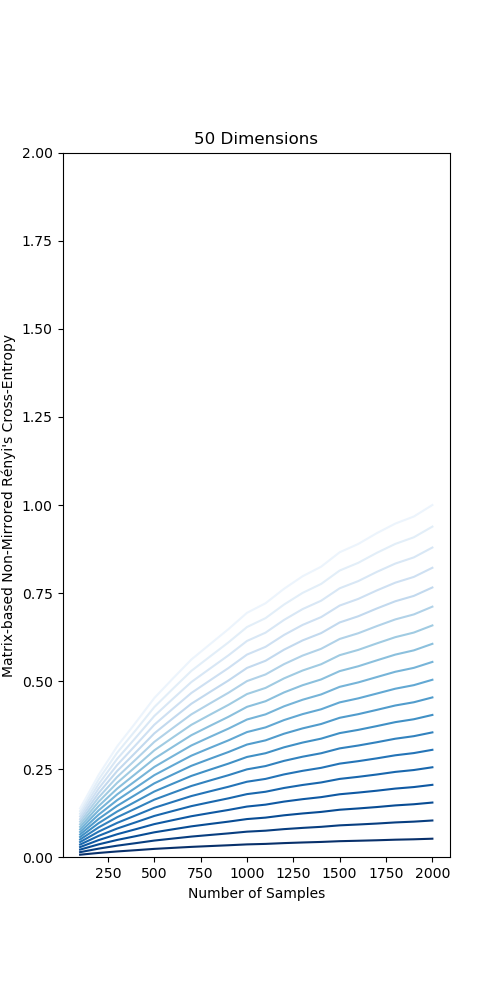

In [97]:
# Normalize the cross-entropies, that way the same aspect can be used regardless of the 
# dimensionality.  This will not change the resulting shape of the curves across 
# different tests of sample dimensionality.
Cnm50 = Cnm50/np.max(Cnm50)

plt.figure()
# Plot each of the rows of the non-mirrored cross-entropy matrix.
for j in range(Cnm50.shape[0]):
    plt.plot(np.arange(100, 2100, 100), Cnm50[j,:], color=cmap(j))

# Annotate the plot.  Set the plot properties.
plt.xlabel('Number of Samples')
plt.ylabel('Matrix-based Non-Mirrored Rényi\'s Cross-Entropy')
plt.title('50 Dimensions')
plt.gca().set_ylim([0,2])
plt.gca().set_aspect(1900)
mpl.pyplot.gcf().set_size_inches(5,10)

plt.show()

In [ ]:
# Create a place-holder matrix to store the cross-entropy magnitudes.  This will be indexed by
# variables i and j.
Cnm100 = np.zeros((len(np.arange(0.05,0.96,0.05)), len(np.arange(100, 2100, 100))))

i = 0
num_dimensions = 100
for num_samples in np.arange(100, 2100, 100):
    j = 0
    # Drawn num_samples from Gaussian distributions with a variance of 0.25
    X1_temp = np.random.normal(loc = distrib_mu, scale = 0.25, size = (num_samples, num_dimensions))
    X2_temp = np.random.normal(loc = distrib_mu, scale = 0.25, size = (num_samples, num_dimensions))
    # Form the Gram matrix for the modified dataset using the Gaussian kernel.  Use the same 
    # hyperparameter values as the second Gram matrix for consistency.  You may encounter weird 
    # results if you consider different kernels with different hyperparameter values.  Also, we 
    # shouldn't need to condition the Gram matrices in this case, so we skip this step.
    kappa1_temp = np.exp(-squareform(pdist(X1_temp))/ker_bandwidth)
    kappa2_temp = np.exp(-squareform(pdist(X2_temp))/ker_bandwidth)
    # Make sure that the Gaussian kernel is implicitly transformed so that it is infinitely-
    # divisible, which is done via normalizing the Gram matrix entries.  Without this step, then 
    # the cross-entropy magnitudes will be negative, not positive.  Also we won't be able to 
    # recover our matrix-based entropies and mutual informations using the cross-entropy measure.
    kappa1_temp = kappa1_temp/kappa1_temp.shape[0]
    kappa2_temp = kappa2_temp/kappa1_temp.shape[0]

    # Sweep over the cross-entropy order and compute the bipartite, non-mirrored cross-entropy.  
    # Iterating over values of alpha illustrates what happens as metric in the probability simplex changes.
    for alpha in np.arange(0.05,0.96,0.05):
        Cnm100[j,i] = nonmirrored_renyi_cross_entropy(kappa1_temp, kappa2_temp, alpha)
        j += 1
    i += 1

<IPython.core.display.Javascript object>


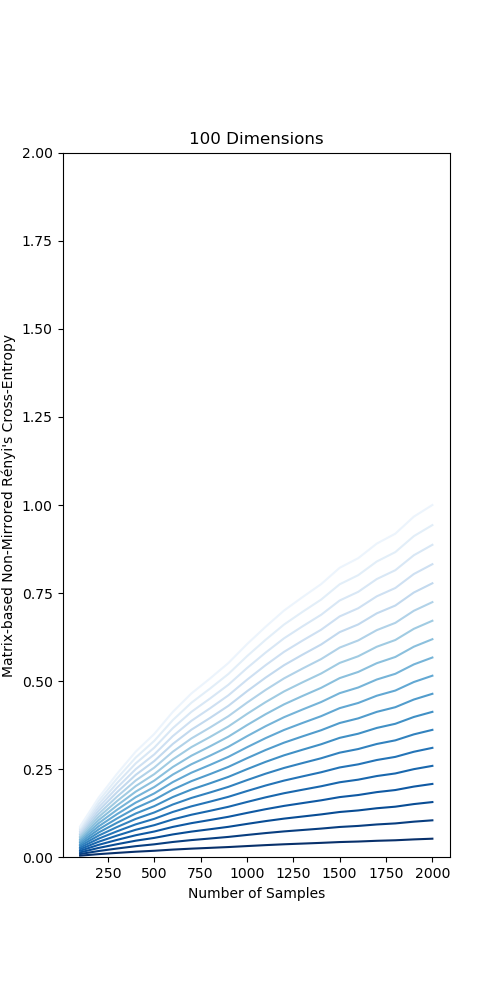

In [94]:
# Normalize the cross-entropies, that way the same aspect can be used regardless of the 
# dimensionality.  This will not change the resulting shape of the curves across 
# different tests of sample dimensionality.
Cnm100 = Cnm100/np.max(Cnm100)

plt.figure()
# Plot each of the rows of the non-mirrored cross-entropy matrix.
for j in range(Cnm100.shape[0]):
    plt.plot(np.arange(100, 2100, 100), Cnm100[j,:], color=cmap(j))

# Annotate the plot.  Set the plot properties.
plt.xlabel('Number of Samples')
plt.ylabel('Matrix-based Non-Mirrored Rényi\'s Cross-Entropy')
plt.title('100 Dimensions')
plt.gca().set_ylim([0,2])
plt.gca().set_aspect(1900)
mpl.pyplot.gcf().set_size_inches(5,10)

plt.show()

We thus see that the matrix-based cross-entropy is insensitive to the dimensionality of the data.  Rather, its convergence rate is determined by the number of samples, just as predicted by theory.